# Global Modelling
This workbook is focused around the task:
- Modelling Oslo's Public Transit Network as a Layered Graph
- Applying Dinic's algorithm for finding max-flow
- Categorizing Sentrality and general inspection of data

## Step 0 - Imports & Data Loading

In [5]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import folium
import numpy as np

#Oslo = county/Fylke 03
nodes_oslo = pd.read_csv("../../Extraction/out/nodes_GTFS_OSLO.csv")
edges_oslo = pd.read_csv("../../Extraction/out/edges_GTFS_OSLO.csv")

#Greater Area: Oslo (03), Akershus(32), Buskerud (33), Østfold (31)
nodes_oslo_extended = pd.read_csv("../../Extraction/out/nodes_GTFS_ALL_FYLKER.csv")
edges_oslo_extended = pd.read_csv("../../Extraction/out/edges_GTFS_ALL_FYLKER.csv")

display(nodes_oslo.head()) 
display(edges_oslo.head())
display(nodes_oslo_extended.head()) 
display(edges_oslo_extended.head())
print(f"Edges shape Oslo: {edges_oslo.shape} | Nodes/Stops shape: {nodes_oslo.shape}")
print("Unique modes in edges:", edges_oslo["mode"].unique())
print("Counts per mode:")
print(edges_oslo["mode"].value_counts())
print(f"\nEdges shape Oslo w/ Selected Neighbours: {edges_oslo_extended.shape} | Nodes/Stops shape: {edges_oslo_extended.shape}")
print("Unique modes in edges:", edges_oslo_extended["mode"].unique())
print("Counts per mode:")
print(edges_oslo_extended["mode"].value_counts())

,id,stopPlaceId,name,lat,lon,modes,stopType
0,NSR:Quay:99688,NSR:Quay:99688,Vækerø,59.915650,10.651833,"bus,coach service",multimodal
1,NSR:Quay:11880,NSR:Quay:11880,Maritim,59.918496,10.667065,"bus,coach service",multimodal
2,NSR:Quay:11829,NSR:Quay:11829,Sjølyst,59.920456,10.676683,"bus,coach service",multimodal
3,NSR:Quay:7700,NSR:Quay:7700,Vika atrium,59.910762,10.722139,"bus,coach service",multimodal
4,NSR:Quay:11969,NSR:Quay:11969,Oslo bussterminal,59.911940,10.756710,bus,bus


,from,to,lineId,lineCode,mode,authority,travelTimeSec,tripsInFeed,weeklyTrips
0,NSR:Quay:99688,NSR:Quay:11880,BRA:Line:4_6169,169,bus,Brakar,60.0,7,35
1,NSR:Quay:11880,NSR:Quay:11829,BRA:Line:4_6169,169,bus,Brakar,60.0,7,35
2,NSR:Quay:11829,NSR:Quay:7700,BRA:Line:4_6169,169,bus,Brakar,120.0,7,35
3,NSR:Quay:7700,NSR:Quay:11969,BRA:Line:4_6169,169,bus,Brakar,660.0,7,35
4,NSR:Quay:12002,NSR:Quay:7699,BRA:Line:4_6169,169,bus,Brakar,660.0,7,35


,id,stopPlaceId,name,lat,lon,modes,stopType
0,NSR:Quay:1173,NSR:Quay:1173,Oslo lufthavn,60.194220,11.099609,unknown,unknown
1,NSR:Quay:26169,NSR:Quay:26169,Sundvollen sentrum,60.062000,10.309736,bus,bus
2,NSR:Quay:26153,NSR:Quay:26153,Kroksund,60.066087,10.297885,bus,bus
3,NSR:Quay:26147,NSR:Quay:26147,Paddevika,60.074500,10.300500,bus,bus
4,NSR:Quay:26140,NSR:Quay:26140,Vik E16,60.077880,10.287076,"bus,coach service",multimodal


,from,to,lineId,lineCode,mode,authority,travelTimeSec,tripsInFeed,weeklyTrips
0,NSR:Quay:1173,NSR:Quay:1173,AVI:Line:WF_OSL-OSL,Oslo-Oslo,unknown,Avinor,11400.0,5,0
1,NSR:Quay:26169,NSR:Quay:26153,BRA:Line:26_4260,Flybuss Ringerike - Gardermoen,bus,Askeladden Reiser,NaN,6,22
2,NSR:Quay:26153,NSR:Quay:26147,BRA:Line:26_4260,Flybuss Ringerike - Gardermoen,bus,Askeladden Reiser,60.0,6,22
3,NSR:Quay:26147,NSR:Quay:26140,BRA:Line:26_4260,Flybuss Ringerike - Gardermoen,bus,Askeladden Reiser,60.0,6,22
4,NSR:Quay:26140,NSR:Quay:26116,BRA:Line:26_4260,Flybuss Ringerike - Gardermoen,bus,Askeladden Reiser,60.0,6,22


Edges shape Oslo: (4825, 9) | Nodes/Stops shape: (1941, 7)
Unique modes in edges: ['bus' 'rail' 'coach service' 'unknown' 'metro' 'tram']
Counts per mode:
mode
bus              3896
metro             372
tram              300
rail              194
coach service      49
unknown            14
Name: count, dtype: int64

Edges shape Oslo w/ Selected Neighbours: (42538, 9) | Nodes/Stops shape: (42538, 9)
Unique modes in edges: ['unknown' 'bus' 'coach service' 'rail' 'metro' 'tram']
Counts per mode:
mode
bus              40016
rail              1156
coach service      605
metro              404
tram               300
unknown             57
Name: count, dtype: int64


In [4]:
import pandas as pd

# bytt til filnavnet ditt
df = pd.read_csv("../../Extraction/out/edges_GTFS_OSLO.csv")

# sjekk duplikater basert på (from, to, lineId)
dupes = df.duplicated(subset=["from", "to", "lineId"], keep=False)

# hent ut bare de som faktisk er dupes
duplicate_rows = df[dupes]

print("Antall rader totalt:", len(df))
print("Antall duplikater:", duplicate_rows.shape[0])
print("\nUnike kombinasjoner som har mer enn én rad:\n")

# gruppér og tell
dup_groups = (
    duplicate_rows
    .groupby(["from", "to", "lineId"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

print(dup_groups.head(20))


Antall rader totalt: 4825
Antall duplikater: 0

Unike kombinasjoner som har mer enn én rad:

Empty DataFrame
Columns: [from, to, lineId, count]
Index: []


## Step 1: Modelling Nodes and Edges
Before modifying the dataset further, a simple visualization was made to verify the usability of the data

In [60]:
def modelMaker(nodes, edges):  
    # Build the graph from the cleaned DataFrames
    G = nx.DiGraph()
    
    # Add nodes
    for _, row in nodes.iterrows():
        node_id = row["id"]
        G.add_node(
            node_id,
            stopPlaceId=row.get("stopPlaceId"),
            name=row.get("name"),
            lat=row.get("lat"),
            lon=row.get("lon"),
            modes=row.get("modes"),
            stopType=row.get("stopType"),
        )
    
    # Add edges
    for _, row in edges.iterrows():
        u = row["from"]
        v = row["to"]
    
        travel_time = row.get("travelTimeSec", None)
        capacity = 1  # temp, to be defined properly later
    
        G.add_edge(
            u,
            v,
            lineId=row.get("lineId"),
            lineCode=row.get("lineCode"),
            mode=row.get("mode"),
            authority=row.get("authority"),
            travelTimeSec=travel_time,
            capacity=capacity,
        )
    
    # 3) Final graph stats
    print("Graph nodes:", G.number_of_nodes())
    print("Graph edges:", G.number_of_edges())
    
    # 4) Build pos dict once, now guaranteed to exist for all nodes in G
    pos = {
        n: (data["lon"], data["lat"])
        for n, data in G.nodes(data=True)
        if data.get("lon") is not None and data.get("lat") is not None
    }
    print(f"Positions built for {len(pos)} nodes.")
    return G, pos


In [61]:
g_oslo, pos_oslo = modelMaker(nodes_oslo, edges_oslo)
g_oslo_extended, pos_oslo_extended = modelMaker(nodes_oslo_extended, egdes_oslo_extended)

Graph nodes: 1941
Graph edges: 2430
Positions built for 1941 nodes.
Graph nodes: 15838
Graph edges: 21385
Positions built for 15838 nodes.


## Step 2.1: Grouped Plotting
Here we are plotting the entire graph, with all nodes and edges combined

In [62]:
def modelPlotter(graph, position, name, out):
    # Defining Mode Colors to differentiate between modes in Graph
    mode_colors = {
        "bus":        "#1f77b4",   # deep blue
        "tram":       "#d62728",   # strong red
        "metro":      "#9467bd",   # purple 
        "rail":       "#2ca02c",   # green 
        "coach":      "#ff7f0e",   # orange
        "water":      "#17becf",   # teal
        "unknown":    "#7f7f7f",   # neutral gray
    }
    
    edge_colors = [
        mode_colors.get(data["mode"], "gray") 
        for _, _, data in graph.edges(data=True)
    ]
    
    plt.figure(figsize=(12, 14))
    nx.draw(
        graph,
        position,
        node_size=3,
        node_color="black",
        edge_color=edge_colors,
        width=0.2,
        alpha=0.4,
        with_labels=False
    )
    
    plt.title(name, fontsize=16)
    plt.axis("off")
    plt.savefig(out, dpi=300, bbox_inches="tight")
    plt.show()

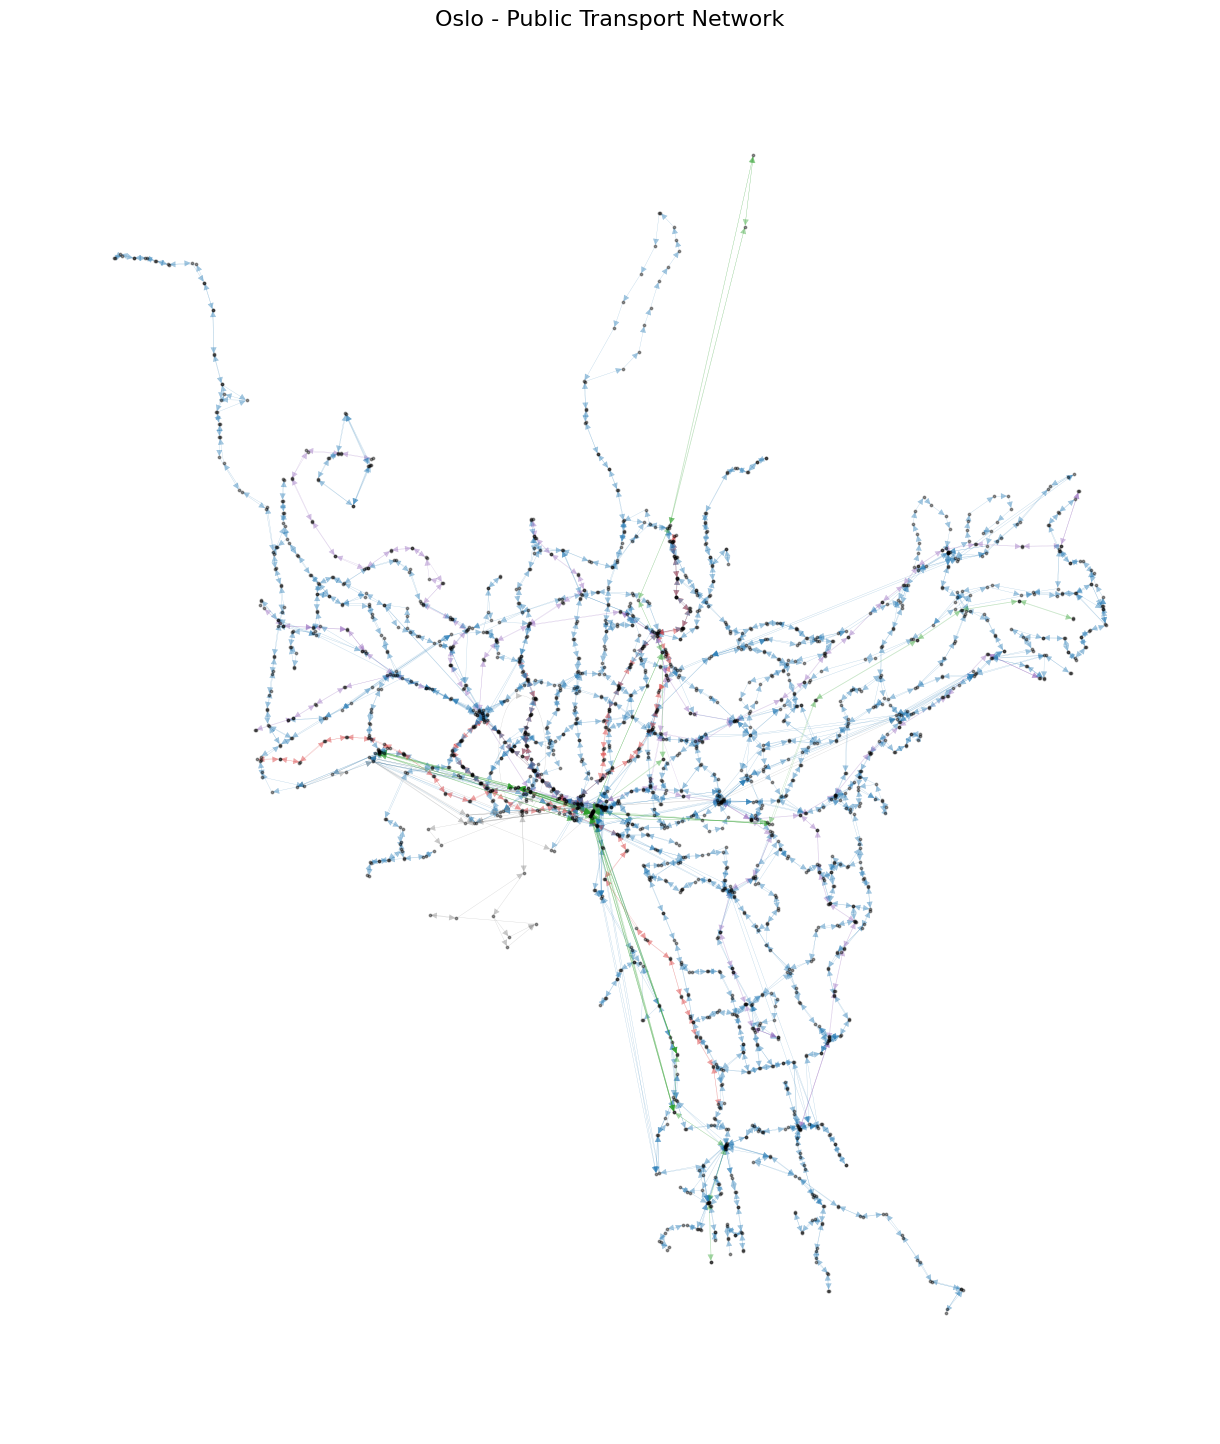

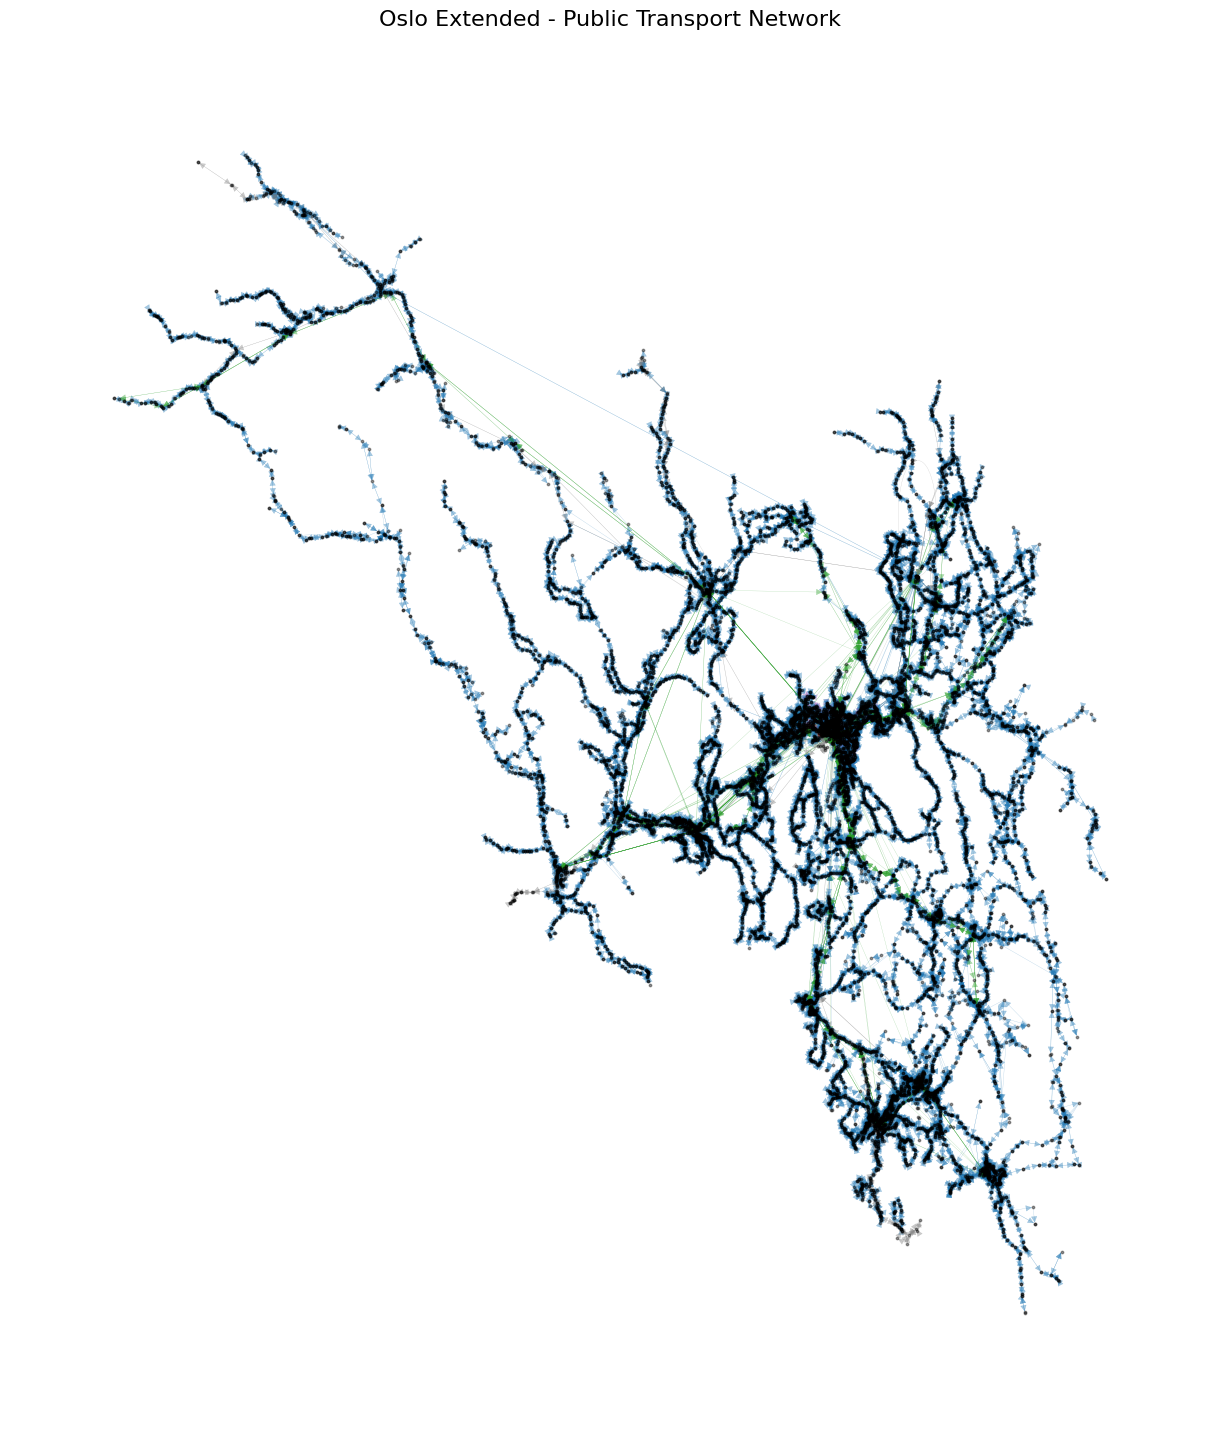

In [63]:
modelPlotter(g_oslo, pos_oslo,"Oslo - Public Transport Network", "images/OsloRawNetworkColorCoded.png")
modelPlotter(g_oslo_extended, pos_oslo_extended,"Oslo Extended - Public Transport Network", "images/OsloExtendedRawNetworkColorCoded.png")

## Step 2.2 Plotting per mode

In [64]:
def modeGroupedPlotter(graph, position, name, out):
    mode_colors = {
        "bus":        "#1f77b4",   # deep blue
        "tram":       "#d62728",   # strong red
        "metro":      "#9467bd",   # purple 
        "rail":       "#2ca02c",   # green 
        "coach":      "#ff7f0e",   # orange
        "water":      "#17becf",   # teal
        "unknown":    "#7f7f7f",   # neutral gray
    }
    modes = ['bus', 'rail', 'coach service', 'metro', 'tram']
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))  # nice and compact
    fig.suptitle(name, fontsize=16)

    for ax, mode in zip(axs.flat, modes):
        ax.set_title(mode.capitalize(), fontsize=10)
    
        edges_of_mode = [
            (u, v) for u, v, data in graph.edges(data=True)
            if data.get("mode") == mode
        ]
    
        nodes_of_mode = set()
        for u, v in edges_of_mode:
            nodes_of_mode.add(u)
            nodes_of_mode.add(v)
    
        edge_colors = [mode_colors.get(mode, "gray")] * len(edges_of_mode)
    
        nx.draw(
            graph,
            position,
            ax=ax,
            with_labels=False,
            nodelist=list(nodes_of_mode),
            edgelist=edges_of_mode,
            node_size=2,        
            node_color="black",
            edge_color=edge_colors,
            width=0.4,          
            alpha=0.9
        )
    
        ax.axis("off")
    axs.flat[-1].axis("off")

    plt.tight_layout()
    plt.savefig(out, dpi=300, bbox_inches="tight")
    plt.show()


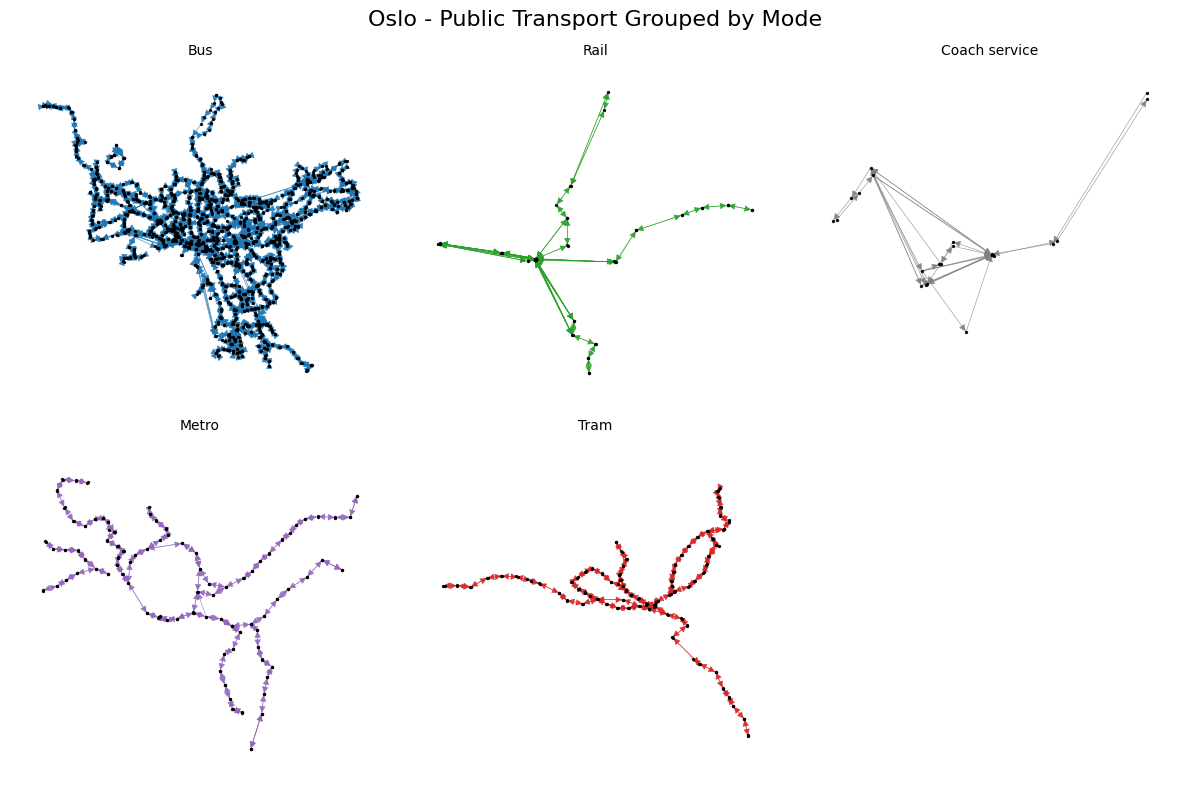

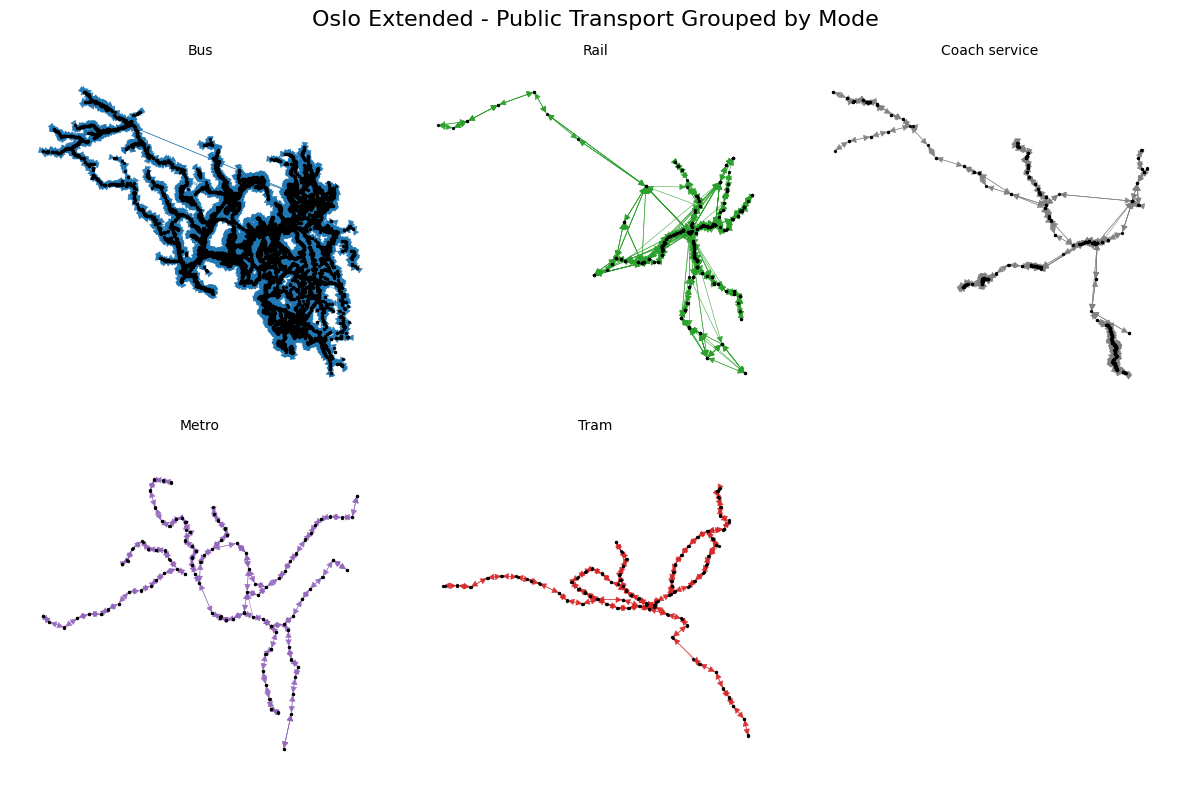

In [65]:
modeGroupedPlotter(g_oslo, pos_oslo,"Oslo - Public Transport Grouped by Mode","images/OsloNetworkGroupedByMode.png")
modeGroupedPlotter(g_oslo_extended, pos_oslo_extended,"Oslo Extended - Public Transport Grouped by Mode","images/OsloExtendedNetworkGroupedByMode.png")

## Step 3 Interactive Map Overlays
Here we are using the Library Folium to overlay our Nodes/Edges latitude and longitude values over an actual map, creating a series for HTML files, which upon inspection can be zoomed in on.

In [79]:
def mapMaker(graph, name):
    mode_colors = {
        "bus":        "#1f77b4",   # deep blue
        "tram":       "#d62728",   # strong red
        "metro":      "#9467bd",   # purple 
        "rail":       "#2ca02c",   # green 
        "coach":      "#ff7f0e",   # orange
        "water":      "#17becf",   # teal
        "unknown":    "#7f7f7f",   # neutral gray
    }
    modes = ['bus', 'rail', 'coach service', 'metro', 'tram']
    for mode in modes:
        m = folium.Map(
            location=[59.9139, 10.7522],
            zoom_start=12,
            tiles="cartodbpositron"
        )
    
        # edges
        for u, v, data in graph.edges(data=True):
            if data.get("mode") != mode:
                continue
    
            lat1, lon1 = graph.nodes[u]["lat"], graph.nodes[u]["lon"]
            lat2, lon2 = graph.nodes[v]["lat"], graph.nodes[v]["lon"]
    
            folium.PolyLine(
                locations=[(lat1, lon1), (lat2, lon2)],
                color=mode_colors.get(mode, "gray"),
                weight=2,
                opacity=0.8
            ).add_to(m)
    
        # nodes
        for n in graph.nodes:
            # only nodes belonging to this mode
            if mode not in graph.nodes[n]["modes"]:
                continue
    
            folium.CircleMarker(
                location=(graph.nodes[n]["lat"], graph.nodes[n]["lon"]),
                radius=2,
                color="black",
                fill=True,
                fill_opacity=1
            ).add_to(m)
    
        # save output
        filename = f"InteractiveView/{name}_{mode.replace(' ', '_')}.html"
        m.save(filename)
        
    
    # 2. MASTER HTML WITH ALL MODES
    m_all = folium.Map(
        location=[59.9139, 10.7522],
        zoom_start=12,
        tiles="cartodbpositron"
    )
    
    # edges
    for u, v, data in graph.edges(data=True):
        lat1, lon1 = graph.nodes[u]["lat"], graph.nodes[u]["lon"]
        lat2, lon2 = graph.nodes[v]["lat"], graph.nodes[v]["lon"]
        mode = data.get("mode")
    
        folium.PolyLine(
            locations=[(lat1, lon1), (lat2, lon2)],
            color=mode_colors.get(mode, "gray"),
            weight=1.5,
            opacity=0.7,
        ).add_to(m_all)
    
    # nodes
    for n in graph.nodes:
        folium.CircleMarker(
            location=(graph.nodes[n]["lat"], graph.nodes[n]["lon"]),
            radius=1.5,
            color="black",
            fill=True,
            fill_opacity=1
        ).add_to(m_all)
    
    m_all.save(name+"_all_modes.html")


In [80]:
mapMaker(g_oslo, "Oslo")
mapMaker(g_oslo_extended, "Oslo_Extended")